In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code is to show how to optimize the parameter of the time-dependent OU processes based on MLE. This code has been vectorized so that it becomes possible to optimize a set of different sample paths at the same time

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [3]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

In [4]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

We simulate two different sample paths from time-dependent OU processes, each of which has the same set of parameters except for $\alpha$ which has a different sign

In [5]:
alpha = torch.tensor([0.633, -0.633]).reshape(2, -1)
beta = torch.tensor([3.59, 3.59]).reshape(2, -1)
r = torch.tensor([1.124, 1.124]).reshape(2, -1)
m0 = torch.tensor([1.79, 1.79]).reshape(2, -1)

In [6]:
true_sde = tOU_vector(t0=0, t1=2, z0=m0, m0=m0, alpha=alpha, beta=beta, sigma=1, r=r, dN=40, D=2, timegrid = 'False')

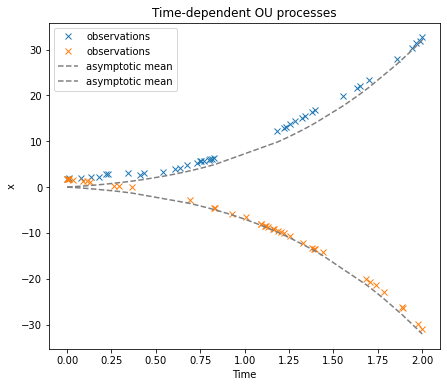

In [7]:
post_mean = lambda x: alpha * (((x + 1) ** beta) - 1) + 0
plt.figure(figsize=(7, 6))
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
plt.plot(true_sde.pts.T, post_mean(true_sde.pts).T, color='grey', linestyle='dashed', label='asymptotic mean')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Time-dependent OU processes")
plt.show()

We make inferences for the parameters of the above sample paths based on gradient descent algorithm. The algorithm is vectorized. 

Note: Gradient descent algorithm is sensitive to initaliziation, in partciular, the sign of $\alpha$. Hence, it is better to initialize $\alpha$ around 0 so that the algorithm finds the right "direction"*

In [ ]:
beta_ = torch.tensor([0.5, 0.5], dtype=torch.float64).reshape(2,-1)
alpha_ = torch.tensor([0., 0.], dtype=torch.float64).reshape(2,-1)
r_ = torch.tensor([1., 1.], dtype=torch.float64).reshape(2,-1)

learning_rate = 0.000005
lr = learning_rate
for i in range(50000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=m0, r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r__ = r_ + learning_rate * update['r']
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while any(r__ < 0):
        for d in range(r__.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
    r_ = r__
        
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

Based on MLE estimator, we sample 50 different sample paths from the time-dependent OU. It is clear that these paths encaptulates our observations.

In [ ]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')

for i in range(50):
    vi = tOU_vector(0, 2, m0, m0, alpha_, beta_, 1., r_, D=2, dN = 30)
    plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

Variational inference: KL

In [14]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        num = func(self.ou.pts, self.ou.trj)

        return torch.trapezoid(abs(num), x=self.ou.pts).reshape(-1, 1)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
            
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1)))


In [15]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [8]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=601)

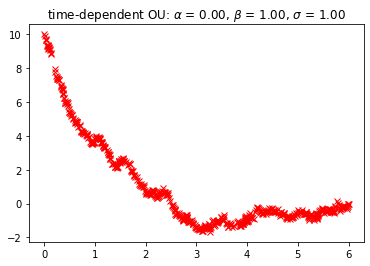

In [9]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [10]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

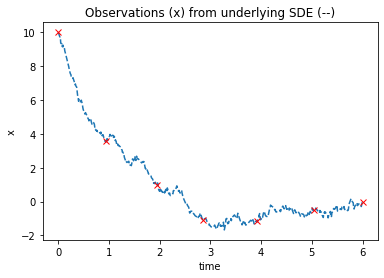

In [11]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [12]:
import tqdm as tq

In [135]:
D = 30

alpha_ = torch.tensor([0.])
beta_ = torch.rand(1)
r_ = torch.rand(1)

m0 = torch.tensor(obs[0]).repeat(D, 1)


learning_rate = 0.00000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    alpha_D = alpha_.repeat(D, 1)
    beta_D = beta_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(torch.tensor(obs[1]).repeat(D, 1)) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((beta_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0, r_D)
    f_of_X = -1 * (elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)) + elbo.KL_ito() + elbo.KL_rest())
    beta_grad = torch.mean(f_of_X * scores['beta'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    beta_ -= learning_rate * beta_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  2%|▊                                          | 6/300 [00:00<00:05, 51.77it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[-0.5920],
        [-5.6915],
        [ 5.1067],
        [ 6.4061],
        [-3.5484],
        [ 0.0647],
        [-2.6117],
        [ 3.9605],
        [ 1.1926],
        [-6.1431],
        [-4.7440],
        [ 4.2093],
        [11.1691],
        [ 9.0546],
        [-3.3315],
        [ 5.7164],
        [ 1.7419],
        [13.7780],
        [ 3.0632],
        [-1.8024],
        [-0.8166],
        [ 4.3664],
        [13.2902],
        [-3.0544],
        [ 1.7456],
        [11.7651],
        [ 0.3372],
        [-0.2994],
        [ 4.8657],
        [-3.4773]], dtype=torch.float64) LL =  tensor([[-20994908.2539],
        [-24428664.1265],
        [-17463385.0276],
        [-16703400.0344],
        [-22954150.0146],
        [-20571452.3325],
        [-22324010.5796],
        [-18147760.2492],
        [-19854226.2401],
        [-24745184.3722],
        [-23771149.0775],
        [-17998089.9899],
    

  6%|██▋                                       | 19/300 [00:00<00:04, 57.36it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e0f72670>> Rest =  tensor([[17.3435],
        [21.9473],
        [14.1929],
        [13.8950],
        [26.4174],
        [ 8.9314],
        [10.6325],
        [ 8.7092],
        [21.3651],
        [18.3897],
        [18.0526],
        [21.6216],
        [11.9597],
        [15.2137],
        [15.9069],
        [22.3746],
        [14.9863],
        [14.5399],
        [16.8595],
        [ 7.0249],
        [12.6745],
        [21.4146],
        [21.3511],
        [10.9169],
        [15.4767],
        [20.5921],
        [20.5671],
        [ 8.8241],
        [12.7978],
        [13.1498]], dtype=torch.float64) LL =  tensor([[-15327747.1470],
        [-12462096.2934],
        [-17456025.0450],
        [-17664283.7297],
        [ -9958597.7604],
        [-21311383.7182],
        [-20023779.4407],
        [-21482447.2025],
        [-12808428.5124],
        [-14651018.5346],
        [-14867454.5200],
        [-12655270.0402],
    

 10%|████▎                                     | 31/300 [00:00<00:04, 57.45it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6043c1310>> Rest =  tensor([[64.0213],
        [65.9345],
        [65.0312],
        [66.6372],
        [65.6451],
        [65.0771],
        [65.5713],
        [64.9200],
        [65.1323],
        [64.8352],
        [65.5957],
        [65.8142],
        [65.0183],
        [65.8860],
        [65.5276],
        [66.0316],
        [65.4559],
        [66.1007],
        [65.1048],
        [65.4381],
        [65.8145],
        [65.6922],
        [64.9575],
        [64.9635],
        [65.8273],
        [66.6716],
        [66.1588],
        [65.7755],
        [65.5004],
        [66.5756]], dtype=torch.float64) LL =  tensor([[-9397244.5996],
        [-2446901.9167],
        [-5265243.6258],
        [ -930633.6948],
        [-3250449.9068],
        [-5100808.9510],
        [-3470973.2294],
        [-5672633.5755],
        [-4905744.6361],
        [-5991450.3271],
        [-3397440.6330],
        [-2769037.7582],
        [-531184

 14%|██████                                    | 43/300 [00:00<00:04, 56.47it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[76.4902],
        [75.2807],
        [75.8550],
        [74.2508],
        [74.3445],
        [73.5665],
        [75.4570],
        [77.6959],
        [76.5987],
        [69.5330],
        [74.6353],
        [71.3749],
        [75.4253],
        [75.3859],
        [73.7952],
        [72.3901],
        [74.8309],
        [70.8968],
        [69.1706],
        [72.3821],
        [74.1454],
        [73.9872],
        [78.2427],
        [74.3810],
        [75.1319],
        [75.0253],
        [72.5732],
        [77.2433],
        [77.1242],
        [78.1216]], dtype=torch.float64) LL =  tensor([[-2.0571e+05],
        [-5.5108e+04],
        [-1.1464e+05],
        [-2.3630e+03],
        [-4.2953e+03],
        [-5.5997e+03],
        [-7.1084e+04],
        [-4.5150e+05],
        [-2.2390e+05],
        [-6.4191e+05],
        [-1.3945e+04],
        [-2.2079e+05],
        [-6.8065e+04],
        [-6.4399e

 18%|███████▋                                  | 55/300 [00:00<00:04, 55.72it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e0fd4460>> Rest =  tensor([[74.6620],
        [76.4679],
        [66.6536],
        [75.6670],
        [68.4015],
        [76.7201],
        [74.6478],
        [80.5104],
        [76.5522],
        [74.4202],
        [76.1082],
        [73.1687],
        [75.6054],
        [76.1173],
        [78.6821],
        [74.5237],
        [74.5659],
        [70.8712],
        [80.5268],
        [74.7633],
        [71.0564],
        [76.2687],
        [72.8114],
        [74.6447],
        [72.9680],
        [70.3440],
        [72.5963],
        [69.5714],
        [76.0388],
        [74.2365]], dtype=torch.float64) LL =  tensor([[-1.3636e+03],
        [-7.1048e+04],
        [-1.9094e+06],
        [-1.7394e+04],
        [-1.1848e+06],
        [-9.5459e+04],
        [-1.5464e+03],
        [-8.9590e+05],
        [-7.8811e+04],
        [-6.0232e+03],
        [-4.2469e+04],
        [-8.2909e+04],
        [-1.4769e+04],
        [-4.3095e

 22%|█████████▍                                | 67/300 [00:01<00:04, 57.35it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6043c1310>> Rest =  tensor([[73.3410],
        [75.3378],
        [79.3662],
        [76.5156],
        [73.1683],
        [77.2592],
        [76.2420],
        [75.4689],
        [80.3032],
        [75.3980],
        [75.1365],
        [79.4330],
        [73.7737],
        [74.3982],
        [72.5966],
        [71.8704],
        [78.8329],
        [73.6410],
        [73.2108],
        [78.2081],
        [73.4431],
        [78.4381],
        [72.9145],
        [73.8552],
        [71.6957],
        [79.7542],
        [72.6989],
        [73.8600],
        [78.2485],
        [76.0849]], dtype=torch.float64) LL =  tensor([[-1.2799e+05],
        [-1.2706e+02],
        [-4.6988e+05],
        [-3.7037e+04],
        [-1.5034e+05],
        [-1.0314e+05],
        [-2.1048e+04],
        [-1.1895e+02],
        [-7.1793e+05],
        [ 4.7983e+00],
        [-2.1487e+03],
        [-4.8584e+05],
        [-7.9913e+04],
        [-3.0408e

 26%|███████████                               | 79/300 [00:01<00:03, 57.08it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e14ed5e0>> Rest =  tensor([[75.9246],
        [70.6980],
        [78.5790],
        [75.0452],
        [75.8396],
        [76.7381],
        [76.6440],
        [78.0076],
        [75.2022],
        [74.5614],
        [80.2823],
        [76.6600],
        [79.9100],
        [74.6019],
        [80.0028],
        [79.5850],
        [78.1048],
        [72.8369],
        [77.5924],
        [75.2232],
        [73.9888],
        [78.4414],
        [71.9640],
        [75.9019],
        [80.1706],
        [74.3799],
        [76.0021],
        [75.5471],
        [76.3893],
        [77.7093]], dtype=torch.float64) LL =  tensor([[-4.3923e+01],
        [-8.7717e+05],
        [-2.1324e+05],
        [-2.6523e+04],
        [-4.8349e+02],
        [-1.8719e+04],
        [-1.4444e+04],
        [-1.3034e+05],
        [-1.8229e+04],
        [-6.1841e+04],
        [-5.7992e+05],
        [-1.5132e+04],
        [-4.8453e+05],
        [-5.8323e

 30%|████████████▋                             | 91/300 [00:01<00:03, 57.12it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6043c1310>> Rest =  tensor([[80.8760],
        [75.5285],
        [74.6038],
        [75.9355],
        [80.1723],
        [79.2672],
        [77.8305],
        [74.3890],
        [75.6074],
        [80.0425],
        [74.6353],
        [82.0669],
        [79.1063],
        [77.5174],
        [75.0309],
        [75.6545],
        [77.0085],
        [77.7425],
        [75.4029],
        [73.1162],
        [74.6364],
        [83.9644],
        [75.6294],
        [75.5852],
        [76.4109],
        [78.0999],
        [76.4570],
        [79.7738],
        [78.9512],
        [78.0914]], dtype=torch.float64) LL =  tensor([[ -591198.0402],
        [  -47403.3533],
        [ -152246.9580],
        [  -20161.0724],
        [ -409720.1151],
        [ -224644.2549],
        [  -43761.1577],
        [ -185190.3568],
        [  -41221.8222],
        [ -379814.3479],
        [ -147689.9831],
        [ -972597.7554],
        [ -19746

 34%|██████████████                           | 103/300 [00:01<00:03, 55.13it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[71.6756],
        [78.4942],
        [80.0129],
        [77.7794],
        [76.1069],
        [81.2174],
        [76.7977],
        [77.4954],
        [79.9997],
        [82.4182],
        [74.4321],
        [80.9322],
        [79.4151],
        [80.9750],
        [79.0861],
        [79.3464],
        [80.5283],
        [76.6941],
        [80.5484],
        [79.1560],
        [78.5558],
        [75.3420],
        [78.3127],
        [79.4136],
        [78.0903],
        [79.3139],
        [75.9966],
        [73.5217],
        [79.4121],
        [81.8719]], dtype=torch.float64) LL =  tensor([[-1.1121e+06],
        [-2.4786e+04],
        [-1.7884e+05],
        [-1.0153e+03],
        [-6.9204e+04],
        [-3.9980e+05],
        [-1.9867e+04],
        [-3.1823e+02],
        [-1.7689e+05],
        [-7.0573e+05],
        [-3.1418e+05],
        [-3.3966e+05],
        [-1.0150e+05],
        [-3.4837e

 38%|███████████████▋                         | 115/300 [00:02<00:03, 54.77it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e0f72670>> Rest =  tensor([[77.5257],
        [79.6072],
        [79.9501],
        [77.1828],
        [79.2842],
        [79.4612],
        [75.5207],
        [77.8103],
        [83.5949],
        [77.6651],
        [75.1687],
        [72.1592],
        [78.6187],
        [77.0403],
        [79.5470],
        [75.4229],
        [74.1706],
        [75.5448],
        [76.4432],
        [82.2070],
        [75.4819],
        [84.0698],
        [76.7589],
        [80.4197],
        [79.5335],
        [73.1520],
        [79.8015],
        [84.7975],
        [79.2629],
        [76.9808]], dtype=torch.float64) LL =  tensor([[  -14569.5386],
        [  -58675.1351],
        [  -91014.7330],
        [  -32708.3356],
        [  -34648.2736],
        [  -47040.1985],
        [ -224501.4196],
        [   -5018.9962],
        [ -860935.0789],
        [   -9271.8564],
        [ -287455.9674],
        [-1152627.1230],
        [   -493

 42%|█████████████████▎                       | 127/300 [00:02<00:03, 56.28it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e13fbe50>> Rest =  tensor([[82.7255],
        [76.5688],
        [77.3358],
        [83.1131],
        [81.9601],
        [80.4445],
        [76.4629],
        [74.5233],
        [78.6738],
        [81.0077],
        [78.9837],
        [76.8849],
        [80.8962],
        [76.9958],
        [80.2060],
        [77.2841],
        [77.7756],
        [80.0111],
        [78.9510],
        [78.8023],
        [80.1233],
        [78.0252],
        [76.0277],
        [77.3951],
        [81.1116],
        [74.0275],
        [83.0052],
        [80.2907],
        [80.7045],
        [80.9645]], dtype=torch.float64) LL =  tensor([[-347428.7811],
        [-190945.8698],
        [ -94417.0000],
        [-426359.6360],
        [-214923.0215],
        [ -45361.1652],
        [-206954.5996],
        [-616997.2598],
        [  -6767.3827],
        [ -93839.4328],
        [   -920.2648],
        [-147035.2924],
        [ -82869.6795],
    

 46%|██████████████████▉                      | 139/300 [00:02<00:02, 54.42it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[76.1515],
        [74.7064],
        [75.0654],
        [80.8588],
        [87.7047],
        [83.1401],
        [77.9762],
        [75.9986],
        [80.0936],
        [80.6227],
        [78.5995],
        [80.2946],
        [77.4821],
        [83.9898],
        [80.4978],
        [75.3391],
        [79.1036],
        [79.5076],
        [79.5694],
        [81.4116],
        [74.5925],
        [83.9875],
        [81.3682],
        [74.0532],
        [82.3412],
        [82.4030],
        [77.6272],
        [72.1384],
        [77.8312],
        [79.4029]], dtype=torch.float64) LL =  tensor([[-4.1529e+05],
        [-7.5925e+05],
        [-6.6392e+05],
        [-6.8827e+03],
        [-1.2340e+06],
        [-1.8433e+05],
        [-1.2985e+05],
        [-4.4670e+05],
        [-1.1535e+03],
        [-2.1975e+03],
        [-6.9657e+04],
        [-4.6057e+00],
        [-1.9097e+05],
        [-3.1063e

 50%|████████████████████▋                    | 151/300 [00:02<00:02, 54.86it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e0fd4460>> Rest =  tensor([[82.0004],
        [77.5041],
        [79.4275],
        [79.4798],
        [79.9870],
        [76.6924],
        [83.1382],
        [78.6903],
        [80.4937],
        [76.4282],
        [77.2353],
        [73.9154],
        [77.6064],
        [84.1992],
        [81.2666],
        [80.2545],
        [80.4142],
        [81.4895],
        [75.2287],
        [80.1106],
        [80.8936],
        [86.3701],
        [77.6135],
        [75.5428],
        [84.0414],
        [81.0798],
        [82.2317],
        [79.0792],
        [81.7860],
        [78.6798]], dtype=torch.float64) LL =  tensor([[-6.2819e+04],
        [-2.7813e+05],
        [-3.6562e+04],
        [-3.3178e+04],
        [-8.9026e+03],
        [-4.4996e+05],
        [-1.9655e+05],
        [-1.0205e+05],
        [-4.3830e+01],
        [-5.1506e+05],
        [-3.3036e+05],
        [-1.3661e+06],
        [-2.5945e+05],
        [-3.8634e

 54%|██████████████████████▎                  | 163/300 [00:02<00:02, 54.87it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[79.1574],
        [85.4168],
        [77.3722],
        [82.8507],
        [83.9931],
        [88.0918],
        [82.5023],
        [84.0624],
        [73.6626],
        [83.5714],
        [85.4918],
        [80.1651],
        [75.4293],
        [83.9043],
        [82.4887],
        [80.3081],
        [77.1820],
        [81.8725],
        [80.3902],
        [80.5170],
        [82.4744],
        [79.2632],
        [84.1409],
        [81.5181],
        [79.4721],
        [78.6980],
        [76.4766],
        [79.5253],
        [76.5034],
        [83.9650]], dtype=torch.float64) LL =  tensor([[-1.4251e+05],
        [-4.4971e+05],
        [-4.7163e+05],
        [-6.1206e+04],
        [-1.9087e+05],
        [-1.2162e+06],
        [-3.5818e+04],
        [-2.0100e+05],
        [-1.8104e+06],
        [-1.3479e+05],
        [-4.6628e+05],
        [-4.2051e+04],
        [-1.0588e+06],
        [-1.7826e

 58%|███████████████████████▉                 | 175/300 [00:03<00:02, 55.41it/s]

tensor([[-6.7601e+04],
        [-3.0768e+04],
        [-1.0138e+05],
        [-1.2913e+05],
        [-2.1777e+05],
        [-6.3149e+03],
        [-2.6384e+05],
        [-4.3811e+04],
        [-6.2914e+05],
        [-3.4844e+05],
        [-9.4559e+05],
        [-2.7611e+02],
        [-3.2459e+03],
        [-1.4073e+04],
        [-1.0910e+05],
        [-2.5573e+05],
        [-1.7562e+04],
        [-3.1134e+05],
        [-9.0260e+02],
        [-1.2640e+03],
        [-2.6432e+04],
        [-1.4509e+05],
        [-8.5239e+05],
        [-8.4488e+05],
        [-5.4913e+05],
        [-2.6829e+05],
        [-5.7432e+04],
        [-1.2999e+05],
        [-1.0248e+06],
        [-4.5407e+05]], dtype=torch.float64)
Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[80.0190],
        [80.1856],
        [81.9401],
        [80.0985],
        [83.1142],
        [83.9976],
        [83.0679],
        [84.7892],
        [82.7880],
        [79.5791],
        [80.

 62%|█████████████████████████▌               | 187/300 [00:03<00:01, 56.80it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[78.5162],
        [91.0105],
        [84.4677],
        [84.3583],
        [83.2487],
        [80.1575],
        [84.5550],
        [80.4190],
        [81.0919],
        [84.1033],
        [82.7192],
        [85.5731],
        [85.0576],
        [82.8702],
        [88.8380],
        [83.5743],
        [84.1755],
        [80.9616],
        [84.7319],
        [78.6135],
        [84.7937],
        [80.4381],
        [79.5674],
        [80.4739],
        [77.6174],
        [83.0516],
        [78.9384],
        [85.9287],
        [88.5304],
        [83.0551]], dtype=torch.float64) LL =  tensor([[ -445835.5247],
        [-2085006.5815],
        [ -137247.9897],
        [ -123871.0845],
        [  -26561.8228],
        [ -140517.1744],
        [ -148407.6808],
        [ -108026.4465],
        [  -44281.8703],
        [  -95304.1900],
        [   -5188.0608],
        [ -309666.4481],
        [ -22089

 67%|███████████████████████████▎             | 200/300 [00:03<00:01, 58.68it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[83.1718],
        [86.2027],
        [85.0099],
        [81.7369],
        [81.5114],
        [83.2934],
        [80.4717],
        [83.7974],
        [84.8221],
        [82.5909],
        [83.9154],
        [82.7437],
        [81.6501],
        [82.1228],
        [80.6725],
        [84.1029],
        [83.3162],
        [81.1781],
        [82.5370],
        [80.6237],
        [82.9369],
        [88.2101],
        [82.7100],
        [82.2767],
        [82.0756],
        [84.4935],
        [80.8134],
        [84.6598],
        [81.7103],
        [81.6551]], dtype=torch.float64) LL =  tensor([[-5.1524e+02],
        [-2.8745e+05],
        [-1.1299e+05],
        [-5.1181e+04],
        [-7.0617e+04],
        [-1.9085e+03],
        [-2.0187e+05],
        [-1.6942e+04],
        [-9.2661e+04],
        [-6.0010e+03],
        [-2.2596e+04],
        [-2.5993e+03],
        [-5.8285e+04],
        [-2.5229e

 71%|█████████████████████████████            | 213/300 [00:03<00:01, 59.33it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e0f72670>> Rest =  tensor([[89.0266],
        [77.0846],
        [79.3102],
        [85.4870],
        [79.2396],
        [84.7879],
        [83.7917],
        [83.0980],
        [85.4666],
        [83.8312],
        [85.5715],
        [84.8976],
        [81.6317],
        [81.6741],
        [81.3474],
        [84.3283],
        [82.8871],
        [79.7855],
        [86.5613],
        [77.4338],
        [85.8255],
        [81.4248],
        [80.4706],
        [82.1289],
        [79.5937],
        [81.6988],
        [83.8053],
        [88.5931],
        [83.2525],
        [85.7460]], dtype=torch.float64) LL =  tensor([[-5.6985e+05],
        [-1.3273e+06],
        [-6.0584e+05],
        [-4.5496e+04],
        [-6.2422e+05],
        [-1.0845e+04],
        [-2.7659e+03],
        [-2.6493e+04],
        [-4.4153e+04],
        [-2.1482e+03],
        [-5.1276e+04],
        [-1.4721e+04],
        [-1.5854e+05],
        [-1.5312e

 76%|███████████████████████████████          | 227/300 [00:04<00:01, 60.23it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[83.5899],
        [86.5762],
        [82.6471],
        [85.1182],
        [84.3155],
        [84.4566],
        [82.9842],
        [83.3727],
        [87.4847],
        [86.8987],
        [79.0326],
        [83.1071],
        [91.7182],
        [84.9957],
        [86.0485],
        [84.0170],
        [86.5560],
        [85.8982],
        [84.8030],
        [85.6217],
        [85.6443],
        [87.1766],
        [85.6661],
        [85.1312],
        [82.8752],
        [85.1512],
        [78.3449],
        [80.7362],
        [87.2930],
        [86.0070]], dtype=torch.float64) LL =  tensor([[-2.0081e+03],
        [-2.2213e+05],
        [-4.4934e+04],
        [-4.9148e+04],
        [-6.7753e+03],
        [-1.1430e+04],
        [-2.3099e+04],
        [-6.9137e+03],
        [-3.9015e+05],
        [-2.7659e+05],
        [-7.6217e+05],
        [-1.6945e+04],
        [-1.7377e+06],
        [-4.0207e

 78%|███████████████████████████████▉         | 234/300 [00:04<00:01, 60.33it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[84.3076],
        [86.5728],
        [86.8061],
        [83.0604],
        [87.1257],
        [85.0985],
        [82.6835],
        [82.6582],
        [88.4603],
        [83.7094],
        [81.9045],
        [86.1591],
        [82.9469],
        [87.1731],
        [83.4768],
        [89.6331],
        [83.9183],
        [86.9878],
        [86.9748],
        [85.7235],
        [82.8941],
        [82.9939],
        [87.2957],
        [84.1833],
        [83.9656],
        [86.7311],
        [87.9783],
        [88.4372],
        [82.6115],
        [79.0135]], dtype=torch.float64) LL =  tensor([[-3.7209e+04],
        [-2.4058e+04],
        [-3.6282e+04],
        [-1.5076e+05],
        [-5.7022e+04],
        [-4.9525e+03],
        [-2.0059e+05],
        [-2.0419e+05],
        [-1.9257e+05],
        [-8.1954e+04],
        [-3.2700e+05],
        [-8.4949e+03],
        [-1.6500e+05],
        [-6.0490e

 83%|█████████████████████████████████▉       | 248/300 [00:04<00:00, 60.48it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6043c1310>> Rest =  tensor([[85.3527],
        [83.4329],
        [92.1980],
        [83.7193],
        [86.6573],
        [86.4549],
        [89.4690],
        [85.7315],
        [85.1160],
        [82.1931],
        [87.4562],
        [84.0058],
        [86.0311],
        [84.0974],
        [84.6638],
        [83.8235],
        [77.9367],
        [85.2611],
        [84.4996],
        [90.4576],
        [85.1463],
        [83.5697],
        [88.4222],
        [84.5150],
        [88.1038],
        [85.5738],
        [84.5289],
        [82.9391],
        [78.0970],
        [83.0602]], dtype=torch.float64) LL =  tensor([[-3.7656e+01],
        [-1.0059e+05],
        [-1.2084e+06],
        [-7.1997e+04],
        [-4.9267e+04],
        [-3.5640e+04],
        [-4.5475e+05],
        [-4.8246e+03],
        [-1.0744e+03],
        [-2.8177e+05],
        [-1.2398e+05],
        [-4.8245e+04],
        [-1.4166e+04],
        [-4.1674e

 87%|███████████████████████████████████▊     | 262/300 [00:04<00:00, 60.46it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e14ed5e0>> Rest =  tensor([[86.6960],
        [90.9961],
        [87.8939],
        [88.1635],
        [84.4557],
        [86.8986],
        [87.1910],
        [87.4699],
        [84.3954],
        [85.6045],
        [88.4619],
        [90.4060],
        [85.2278],
        [88.2344],
        [84.4301],
        [86.2000],
        [79.3703],
        [84.3931],
        [87.9298],
        [84.3995],
        [84.0079],
        [85.6330],
        [87.8567],
        [86.9292],
        [86.9986],
        [88.4113],
        [84.3575],
        [82.8515],
        [82.9629],
        [89.6347]], dtype=torch.float64) LL =  tensor([[-2.7898e+04],
        [-7.4296e+05],
        [-1.3290e+05],
        [-1.6693e+05],
        [-4.4602e+04],
        [-4.0264e+04],
        [-6.2019e+04],
        [-8.7025e+04],
        [-4.9080e+04],
        [-2.4187e+02],
        [-2.0895e+05],
        [-5.9111e+05],
        [-6.3139e+03],
        [-1.7650e

 92%|█████████████████████████████████████▋   | 276/300 [00:04<00:00, 60.61it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc6105dde80>> Rest =  tensor([[83.2774],
        [90.5320],
        [81.4519],
        [84.6495],
        [88.7164],
        [84.5448],
        [87.0718],
        [85.4761],
        [85.2842],
        [86.1315],
        [92.5646],
        [84.0971],
        [86.1448],
        [86.7400],
        [86.1826],
        [84.4734],
        [89.8663],
        [86.3708],
        [84.5687],
        [84.2847],
        [87.8852],
        [85.0083],
        [85.3740],
        [84.0372],
        [85.9116],
        [85.3254],
        [84.8407],
        [88.0736],
        [85.9956],
        [83.8565]], dtype=torch.float64) LL =  tensor([[-2.2706e+05],
        [-6.1679e+05],
        [-6.7043e+05],
        [-5.1278e+04],
        [-2.3294e+05],
        [-6.0179e+04],
        [-4.0527e+04],
        [-6.1677e+03],
        [-1.2701e+04],
        [-1.3818e+03],
        [-1.2438e+06],
        [-1.0654e+05],
        [-1.5608e+03],
        [-2.0648e

 97%|███████████████████████████████████████▋ | 290/300 [00:05<00:00, 60.77it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc61063c790>> Rest =  tensor([[83.2207],
        [86.7130],
        [83.1051],
        [89.8356],
        [88.4314],
        [86.8909],
        [90.9705],
        [84.9401],
        [84.8862],
        [87.1205],
        [88.0279],
        [87.7434],
        [85.6690],
        [89.4372],
        [87.9325],
        [89.4510],
        [86.8423],
        [86.3886],
        [86.4035],
        [83.6473],
        [88.5688],
        [89.0040],
        [88.3869],
        [86.6552],
        [86.4245],
        [87.4231],
        [87.5812],
        [88.0647],
        [90.5694],
        [85.2791]], dtype=torch.float64) LL =  tensor([[-334880.4910],
        [  -9383.9115],
        [-362286.3403],
        [-440266.6998],
        [-170301.4515],
        [ -16909.9503],
        [-742869.9981],
        [ -57591.1027],
        [ -62709.4525],
        [ -29817.3478],
        [-115205.3454],
        [ -82619.2437],
        [ -10004.0238],
    

100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 57.63it/s]

Ito =  <bound method ELBO.KL_ito of <__main__.ELBO object at 0x7fc5e13fbe50>> Rest =  tensor([[86.8664],
        [90.6782],
        [84.3159],
        [88.5830],
        [84.0208],
        [83.0975],
        [92.4546],
        [89.5885],
        [85.9396],
        [81.9730],
        [89.2298],
        [87.4357],
        [88.6757],
        [87.0097],
        [86.1700],
        [90.9578],
        [89.4179],
        [88.9302],
        [88.9026],
        [89.7845],
        [88.6424],
        [90.2042],
        [82.4798],
        [86.6230],
        [90.2450],
        [86.1179],
        [87.1397],
        [89.6512],
        [87.6562],
        [87.2418]], dtype=torch.float64) LL =  tensor([[-1.5415e+04],
        [-2.7205e+05],
        [-3.3806e+05],
        [-2.9508e+04],
        [-4.0422e+05],
        [-6.5289e+05],
        [-6.5473e+05],
        [-1.1639e+05],
        [-8.2829e+04],
        [-1.0452e+06],
        [-7.8989e+04],
        [-6.2093e+02],
        [-3.5160e+04],
        [-9.8227e

**Posterior mean**

In [136]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0[0]

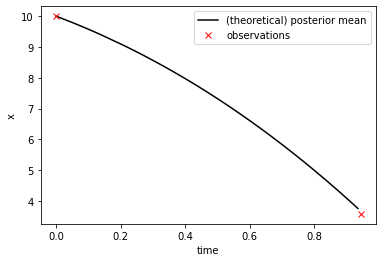

In [137]:
# plt.plot(true_sde.pts[:100], true_mean(true_sde.pts)[:100], color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts[:100], compute_mean(true_sde.pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde.pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

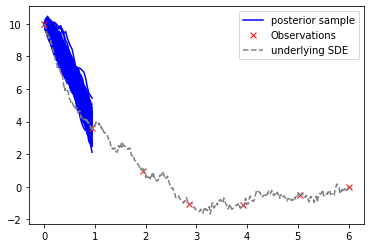

In [138]:
S = 100
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = m0[0].repeat(S, 1), m0 = m0[0].repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

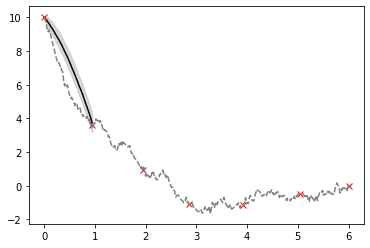

In [139]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

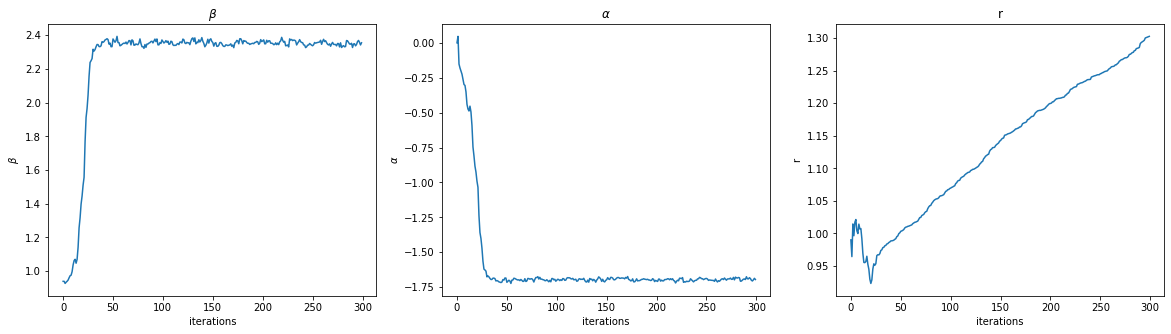

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

pars_traces[0]

In [220]:
D = 80
S = 50
learning_rate = 0.00000005
lr = learning_rate
IT = 300
z0 = torch.tensor(obs[0])

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    beta_ = torch.rand(1)
    r_ = torch.rand(1)
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
#         print("after z0 = ", z0)
        old = alpha_ + beta_ + r_
        
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)

        # Compute (negative) ELBO
        vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo_ = ELBO(vi_)
        elbo_estimate = -1 * (elbo_.log_prob(torch.tensor(obs[t+1]).repeat(D, 1)) + elbo_.KL_ito() + elbo_.KL_rest())
        elbo_traces[t, i] = torch.mean(elbo_estimate).clone()

        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, z0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(torch.tensor(obs[t+1]).repeat(D, 1)) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)))

        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])

        # Update the parameter
        beta_ -= learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

            # It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()
        pars_traces[2, t, i] = r_.clone()

        new = alpha_.clone() + beta_.clone() + r_.clone()
#         conv = abs(old - new)
        i += 1
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy(), "r = ", r_.data.numpy(), "(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
#     print("z0 = ", z0)
    
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = z0.repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/6 [00:00<?, ?it/s]

alpha =  tensor([-1.8367]) beta =  tensor([2.2578]) r =  tensor([0.8862]) (Neg) elbo =  tensor(289495.6245, dtype=torch.float64)
alpha =  tensor([-1.9653]) beta =  tensor([2.3364]) r =  tensor([1.1898]) (Neg) elbo =  tensor(399261.4215, dtype=torch.float64)
alpha =  tensor([-1.9442]) beta =  tensor([2.2352]) r =  tensor([1.4415]) (Neg) elbo =  tensor(188728.8277, dtype=torch.float64)
alpha =  tensor([-1.9524]) beta =  tensor([2.1242]) r =  tensor([1.7012]) (Neg) elbo =  tensor(2346797.0728, dtype=torch.float64)
alpha =  tensor([-1.9689]) beta =  tensor([2.0390]) r =  tensor([1.8651]) (Neg) elbo =  tensor(332084.8815, dtype=torch.float64)


 17%|███████▌                                     | 1/6 [00:12<01:04, 13.00s/it]

alpha =  tensor([-2.0571]) beta =  tensor([2.1404]) r =  tensor([2.0023]) (Neg) elbo =  tensor(108959.9909, dtype=torch.float64)
alpha =  tensor([-0.8427]) beta =  tensor([1.3414]) r =  tensor([0.9842]) (Neg) elbo =  tensor(173955.5035, dtype=torch.float64)
alpha =  tensor([-0.8688]) beta =  tensor([1.3453]) r =  tensor([1.3164]) (Neg) elbo =  tensor(165615.1444, dtype=torch.float64)
alpha =  tensor([-0.8763]) beta =  tensor([1.3348]) r =  tensor([1.5425]) (Neg) elbo =  tensor(165132.7107, dtype=torch.float64)
alpha =  tensor([-0.8919]) beta =  tensor([1.3395]) r =  tensor([1.7142]) (Neg) elbo =  tensor(140673.3572, dtype=torch.float64)
alpha =  tensor([-0.8720]) beta =  tensor([1.3000]) r =  tensor([1.8911]) (Neg) elbo =  tensor(100331.9833, dtype=torch.float64)


 33%|███████████████                              | 2/6 [00:26<00:52, 13.00s/it]

alpha =  tensor([-0.8609]) beta =  tensor([1.2669]) r =  tensor([2.0533]) (Neg) elbo =  tensor(100611.8150, dtype=torch.float64)
alpha =  tensor([-0.8185]) beta =  tensor([1.1250]) r =  tensor([0.9753]) (Neg) elbo =  tensor(153686.0610, dtype=torch.float64)
alpha =  tensor([-0.7760]) beta =  tensor([1.0427]) r =  tensor([1.2813]) (Neg) elbo =  tensor(221503.1346, dtype=torch.float64)
alpha =  tensor([-0.8328]) beta =  tensor([1.1100]) r =  tensor([1.5301]) (Neg) elbo =  tensor(128411.2802, dtype=torch.float64)
alpha =  tensor([-0.7872]) beta =  tensor([1.0168]) r =  tensor([1.7232]) (Neg) elbo =  tensor(136378.0106, dtype=torch.float64)
alpha =  tensor([-0.8168]) beta =  tensor([1.0400]) r =  tensor([1.9058]) (Neg) elbo =  tensor(85687.5908, dtype=torch.float64)


 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.07s/it]

alpha =  tensor([-0.8299]) beta =  tensor([1.0417]) r =  tensor([2.0619]) (Neg) elbo =  tensor(147791.9514, dtype=torch.float64)
alpha =  tensor([-0.0395]) beta =  tensor([0.2958]) r =  tensor([1.0997]) (Neg) elbo =  tensor(270968.2028, dtype=torch.float64)
alpha =  tensor([-0.0532]) beta =  tensor([0.2979]) r =  tensor([1.3903]) (Neg) elbo =  tensor(97023.4722, dtype=torch.float64)
alpha =  tensor([-0.1164]) beta =  tensor([0.3191]) r =  tensor([1.6245]) (Neg) elbo =  tensor(129732.3500, dtype=torch.float64)
alpha =  tensor([-0.0899]) beta =  tensor([0.3067]) r =  tensor([1.8184]) (Neg) elbo =  tensor(120027.5035, dtype=torch.float64)
alpha =  tensor([-0.1219]) beta =  tensor([0.3196]) r =  tensor([1.9710]) (Neg) elbo =  tensor(115616.3343, dtype=torch.float64)


 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.06s/it]

alpha =  tensor([-0.0991]) beta =  tensor([0.3085]) r =  tensor([2.1067]) (Neg) elbo =  tensor(89982.8234, dtype=torch.float64)
alpha =  tensor([0.2132]) beta =  tensor([0.8899]) r =  tensor([1.2398]) (Neg) elbo =  tensor(170018.8691, dtype=torch.float64)
alpha =  tensor([0.1847]) beta =  tensor([0.8455]) r =  tensor([1.5122]) (Neg) elbo =  tensor(149560.3563, dtype=torch.float64)
alpha =  tensor([0.2212]) beta =  tensor([0.8338]) r =  tensor([1.7253]) (Neg) elbo =  tensor(154437.2681, dtype=torch.float64)
alpha =  tensor([0.2460]) beta =  tensor([0.8280]) r =  tensor([1.9022]) (Neg) elbo =  tensor(107422.1877, dtype=torch.float64)
alpha =  tensor([0.2277]) beta =  tensor([0.8005]) r =  tensor([2.0516]) (Neg) elbo =  tensor(148144.0947, dtype=torch.float64)


 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.09s/it]

alpha =  tensor([0.2262]) beta =  tensor([0.7815]) r =  tensor([2.1888]) (Neg) elbo =  tensor(98073.5265, dtype=torch.float64)
alpha =  tensor([0.1733]) beta =  tensor([0.9554]) r =  tensor([1.0667]) (Neg) elbo =  tensor(254240.3888, dtype=torch.float64)
alpha =  tensor([0.1114]) beta =  tensor([0.8691]) r =  tensor([1.3279]) (Neg) elbo =  tensor(181603.8427, dtype=torch.float64)
alpha =  tensor([0.1082]) beta =  tensor([0.8405]) r =  tensor([1.5530]) (Neg) elbo =  tensor(226394.2896, dtype=torch.float64)
alpha =  tensor([0.1566]) beta =  tensor([0.8122]) r =  tensor([1.7476]) (Neg) elbo =  tensor(92698.9119, dtype=torch.float64)
alpha =  tensor([0.1663]) beta =  tensor([0.7953]) r =  tensor([1.9127]) (Neg) elbo =  tensor(110384.4240, dtype=torch.float64)


100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.08s/it]

alpha =  tensor([0.1275]) beta =  tensor([0.7600]) r =  tensor([2.0555]) (Neg) elbo =  tensor(143772.9031, dtype=torch.float64)


Trace plot: ELBO

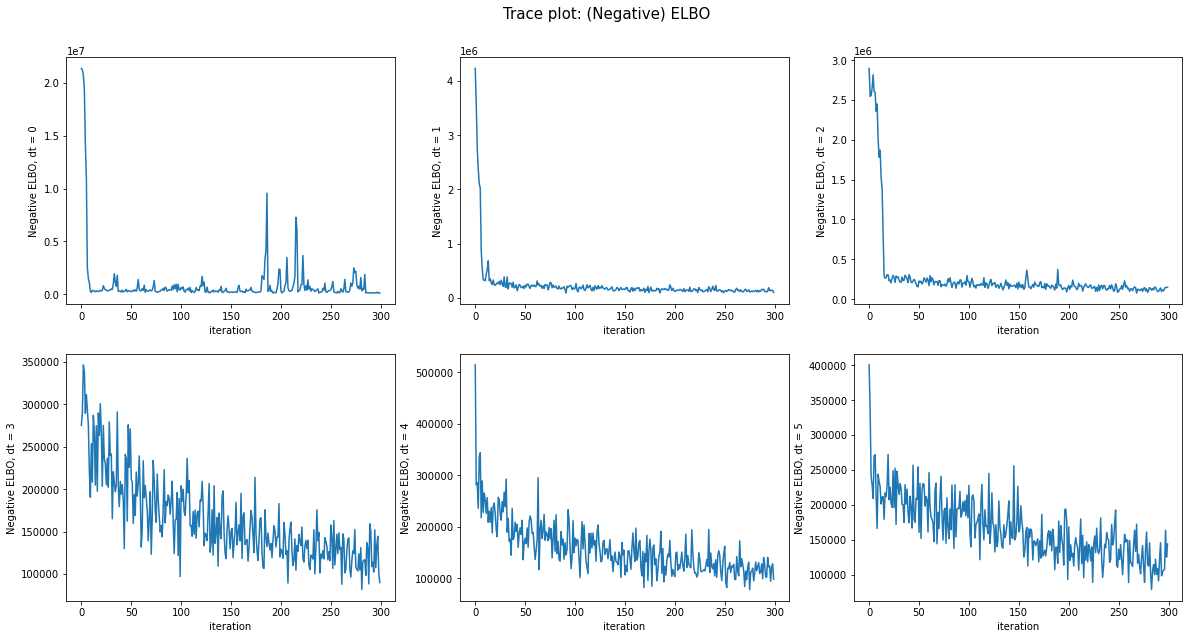

In [221]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

**Posterior approximation**

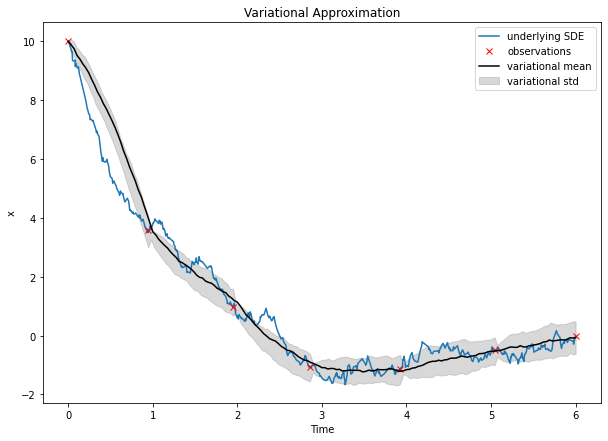

In [222]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts, true_sde.trj, label="underlying SDE")
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 6, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()